In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras.utils import np_utils
from keras import utils
from sklearn.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data set
df_train = pd.read_csv("/content/drive/MyDrive/MLHC_PROJECT1/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("/content/drive/MyDrive/MLHC_PROJECT1/mitbih_test.csv", header=None)

y_train = np.array(df_train[187].values).astype(np.int8)
X_train = np.array(df_train[list(range(187))].values)[..., np.newaxis]

y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [ ]:
ensemble_predictions = np.zeros((21892, 5))

path = "/content/drive/MyDrive/MLHC_PROJECT1/H5/MIT/"
import os
for filename in os.listdir(path):
  print(filename)
  model = keras.models.load_model(path + filename)

  y_pred = model.predict(X_test)
  ensemble_predictions = ensemble_predictions + y_pred

CNN_mit.h5
transformer_mit.h5


In [ ]:
y_pred = np.argmax(ensemble_predictions, axis=-1)

f1 = f1_score(y_test, y_pred, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, y_pred)
print("Test accuracy score : %s "% acc)

Test f1 score : 0.8901330367054285 
Test accuracy score : 0.9813630549972593 


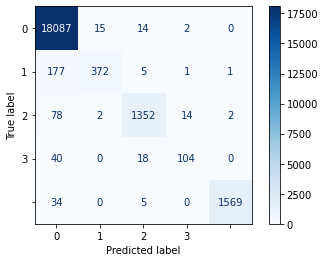

In [ ]:
# Plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])

disp.plot(cmap=plt.cm.Blues)
plt.show()